# install library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets

In [ ]:
!pip install transformers

In [ ]:
!pip install accelerate

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from datasets import load_dataset, DatasetDict, Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score,recall_score
from transformers import TrainingArguments,AutoModelForSequenceClassification,Trainer,AutoTokenizer,DataCollatorWithPadding

# Load data training từ huggingface

In [ ]:
rawdata = load_dataset("yelp_review_full")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
rawdata

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})

In [ ]:
rawdata["train"].features

{'label': ClassLabel(names=['1 star', '2 star', '3 stars', '4 stars', '5 stars'], id=None),
 'text': Value(dtype='string', id=None)}

In [ ]:
rawdata["test"].features

{'label': ClassLabel(names=['1 star', '2 star', '3 stars', '4 stars', '5 stars'], id=None),
 'text': Value(dtype='string', id=None)}

In [ ]:
# Tạo một bản sao của rawdata
emotions = copy.deepcopy(rawdata)

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,label,text
0,4,dr. goldberg offers everything i look for in a...
1,1,"Unfortunately, the frustration of being Dr. Go..."
2,3,Been going to Dr. Goldberg for over 10 years. ...
3,3,Got a letter in the mail last week that said D...
4,0,I don't know what Dr. Goldberg was like before...


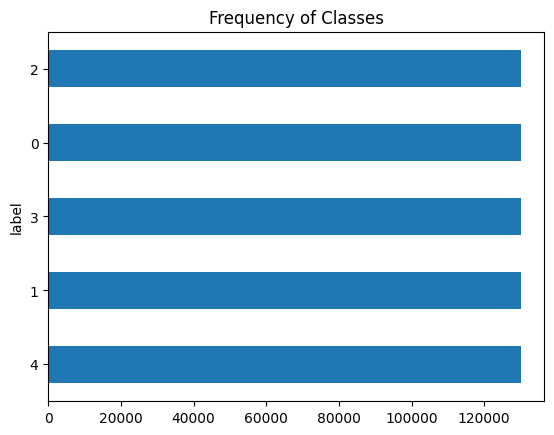

In [ ]:
df["label"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

# Tokenization

In [ ]:
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def tokenize_function(example):
    return tokenizer(example["text"], padding=True, truncation=True)

In [ ]:
tokenized_datasets = rawdata.map(tokenize_function, batched=True)

Map:   0%|          | 0/650000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
print(tokenized_datasets["train"].column_names)

['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask']


In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Train model

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average="weighted")
    recall = recall_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1, "precision": precision,"recall": recall}

In [ ]:
# Kiểm tra xem GPU có sẵn không
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU")

GPU is available


In [ ]:
batch_size = 32
training_args = TrainingArguments(output_dir ="BERT650",
                                  num_train_epochs=4,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  disable_tqdm=False,
                                  push_to_hub=True,
                                  warmup_steps=1000,
                                  fp16=True,
                                  warmup_ratio=0.1,
                                  #ignore_data_skip = True,
                                  log_level="error")


In [ ]:
model = (AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=5).to(device))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=tokenized_datasets["train"],
                  eval_dataset=tokenized_datasets["test"],
                  tokenizer=tokenizer)

In [ ]:
trainer.train()
#trainer.train(resume_from_checkpoint=True)

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
trainer.push_to_hub(commit_message="Training completed!")

NameError: name 'trainer' is not defined

In [ ]:
label_names = rawdata["train"].features["label"].names
label_names

In [ ]:
# Đổi tên nhãn trong label_names
label_names = ['1', '2', '3', '4', '5']
label_names

In [ ]:
model.config.id2label = {str(i): lbl for i, lbl in enumerate(label_names)}
model.config.label2id = {lbl: str(i) for i, lbl in enumerate(label_names)}

In [ ]:
repo_name = "TungLe7661/BERT650"
model.config.push_to_hub(repo_name)